# 3.0 - evaluate BERT

This notebook utilizes the approach I have described in previous notebooks to evaluate BERT substitution of words in a sentence to replace toxic ones.

The approach is as follows:

- take a subset of the raw data where the toxicity is significantly reduced (0.9 -> 0.1) because the dataset itself is quite noisy (some sentences do not have any meaning).
- divide into training and testing subsets
- create a toxic-words vocabulary from the training subset
- for each sentence in the testing subset, substitute each toxic word with a word from the vocabulary and calculate BLEU score + evaluate on toxicity using different model

### Model to analyze toxicity

I have decided not to invent the wheel and take [some pretrained model](https://huggingface.co/martin-ha/toxic-comment-model?text=He+is+the+tallest+son+of+bitch) which gives score from 0 to 1 of how toxic the sentence is.

I will collect the scores for testing set so it would be possible to compare.

#### Note:

I will split into training and testing set the data in script [`src/data/split_dataset.py`](../src/data/split_dataset.py) so it will be possible to compare different models on exact one collections of data.


In [1]:
import pandas as pd

# load test dataset
df = pd.read_csv("../data/interim/train.csv", index_col=0)

df.head()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
Unnamed: 0,,,,,,
314553,I would have killed you long ago--I am an impu...,I would have eliminated you long ago - I'm an ...,0.744656,0.158879,0.939868,0.017794
264409,You're hiding behind your religion to justify ...,you hide behind your faith to apologise to you...,0.856865,0.036145,0.954694,0.065083
206560,Who the fuck you got sending you flowers?,who's sending you flowers?,0.901133,0.357143,0.999471,0.000042
498825,"Come on, Pyecroft, you old buzzard.","come on, Pyecroft, you old adversary.",0.805875,0.052632,0.994935,0.001598
488464,"Love, connect... grow old, die.","to be loved, to live, to grow old, to die.",0.714895,0.255814,0.959821,0.000521


In [2]:
# create a vocabulary from the training data
import sys

# to be able to load modules from src
sys.path.append("..")

from src.data import make_toxic_set

train_toxic_df = make_toxic_set.get_toxic_vocab(df)
train_toxic_df = make_toxic_set.clean_data(train_toxic_df, "toxic_words", "clean")

# save the vocabulary
train_toxic_df.to_csv("../data/interim/train_vocab.csv", index=False)

train_toxic_df.head()

,toxic_words,clean
0,understanding...,understand
1,...early,earli
2,"freddy,",freddi
3,martinets.,martinet
4,pancake,pancak


## Evaluation:

- iterate through validate subset
- for each sentence find and replace ones from train vocabulary using BERT
- evaluate toxicity, original BLEU score and after replacement

In [3]:
# load model
from transformers import pipeline

unmasker = pipeline("fill-mask", model="bert-base-uncased")

/home/leo/github.com/lvjonok/f23-pmldl/f23-pmldl-assignment1/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
# load validation dataset
df = pd.read_csv("../data/interim/val_subset.csv", index_col=0)

df.head()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
Unnamed: 0,,,,,,
314081,But the French will hog them all.,but I guess the French will eat them.,0.640306,0.105263,0.930104,0.001689
284848,Gay? Oh! I can't even say it.,I can't even say.,0.680517,0.400000,0.982420,0.000055
148298,"He come round at night, kicked my door in, dra...","he came out that night, knocked out the door, ...",0.730038,0.243697,0.995085,0.002226
211184,Of course he rolled his fucking eyes!,that's why he rolled his eyes.,0.710801,0.184211,0.998498,0.000072
14849,I'm the fucking customer here!,I'm your customer!,0.845089,0.387097,0.995472,0.000044


In [5]:
for word in train_toxic_df["clean"]:
    print(word)
    break

understand


In [6]:
from typing import List, Tuple


def mask_sentence(
    sentence: str, toxic_vocab: pd.DataFrame
) -> Tuple[List[str], List[str]]:
    """
    Mask all words in a sentence that are in the toxic vocabulary.

    Returns:
        list of masked sentences, list of masked words
    """

    masked_sentences = []
    masked_words = []

    for word in sentence.split():
        if word in toxic_vocab["clean"].values:
            # clean the word
            word = str(word).lower().strip()

            masked_sentences.append(
                sentence.replace(word, unmasker.tokenizer.mask_token, 1)
            )
            masked_words.append(word)

    return masked_sentences, masked_words


mask_sentence(df["reference"].iat[0], train_toxic_df)

(['But the French [MASK] hog them all.',
  'But the French will [MASK] them all.'],
 ['will', 'hog'])

In [8]:
# load metrics
import evaluate

# Load the BLUE metric
metric = evaluate.load("sacrebleu")

# load toxicity rate metric
toxicity_rater = pipeline("text-classification", model="martin-ha/toxic-comment-model")

In [9]:
import spacy

!python3 -m spacy download en_core_web_md

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_md")


def find_best_bert_result(masked_word, bert_results):
    toxic = nlp(masked_word)
    best_result = None

    for res in bert_results:
        try:
            doc = nlp(res["token_str"])
        except:
            print(res)
            return
        similarity = toxic.similarity(doc)

        if best_result is None or similarity > best_result["similarity"]:
            best_result = {"similarity": similarity, "result": res["token_str"]}

    return best_result

In [10]:
def evaluate(sentence):
    """
    evaluate a sentence:
    - mask all toxic words from given vocabulary
    - find best substitution for each masked word using bert and similarity comparison
    - calculate BLEU score for sentence
    - rate toxicity of the sentence using the external model
    """
    original_sentence = sentence

    masked_sentences, masked_words = mask_sentence(sentence, train_toxic_df)

    results = []
    for masked_sentence, toxic_word in zip(masked_sentences, masked_words):
        bert_results = unmasker(masked_sentence)

        best_result = find_best_bert_result(toxic_word, bert_results)

        results.append(best_result)

    # replace masked words with results
    for i, result in enumerate(results):
        sentence = sentence.replace(masked_words[i], result["result"])

    # calculate scores
    bleu_score = metric.compute(
        predictions=[sentence], references=[[original_sentence]]
    )["score"]

    # evaluate toxicity
    toxicity = toxicity_rater(sentence)[0]

    return {
        "sentence": sentence,
        "bleu_score": bleu_score,
        "rate": toxicity["score"] * (-1 if toxicity["label"] == "toxic" else 1),
    }


evaluate(df["reference"].iat[0])

{'sentence': 'But the French will kill them all.',
 'bleu_score': 50.000000000000014,
 'rate': 0.7264391183853149}

## Compute history of evaluations

We compute only 500 samples because it takes quite long

In [11]:
from tqdm import tqdm

history = []

for sentence in tqdm(df["reference"]):
    history.append(evaluate(sentence))

  0%|          | 0/500 [00:00<?, ?it/s]

 65%|██████▌   | 327/500 [02:35<02:08,  1.34it/s]/tmp/ipykernel_19171/710774423.py:17: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity = toxic.similarity(doc)
100%|██████████| 500/500 [04:16<00:00,  1.95it/s]


In [12]:
# save as pandas dataframe for further comparison
history_df = pd.DataFrame(history)
history_df.to_csv("../data/evaluations/bert.csv", index=False)

history_df.head()

,sentence,bleu_score,rate
0,But the French will kill them all.,50.000000,0.726439
1,Gay? Oh! I can't even say it.,100.000000,0.897282
2,"He came over at night, kicked my legs in, drag...",55.241151,-0.948099
3,Of course he rolled his fucking eyes!,100.000000,-0.953430
4,I'm the fucking customer here!,100.000000,-0.943484


# Analysis

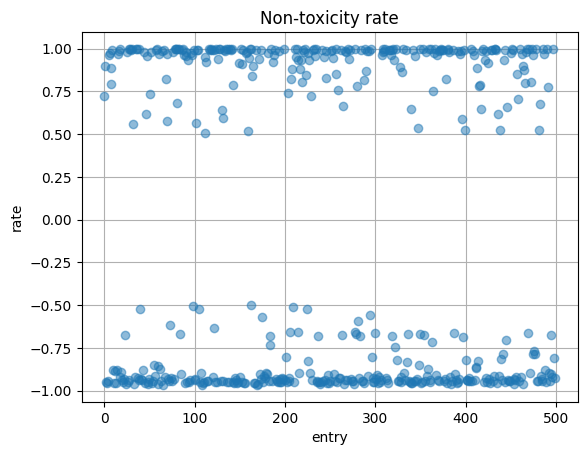

In [17]:
from src.visualization.utils import simple_hist, simple_plot

simple_plot(
    history_df["rate"],
    title="Non-toxicity rate",
    xlabel="entry",
    ylabel="rate",
    save_path="../reports/figures/bert_rate.png",
    marker="o",
    linestyle="None",
    alpha=0.5,
)

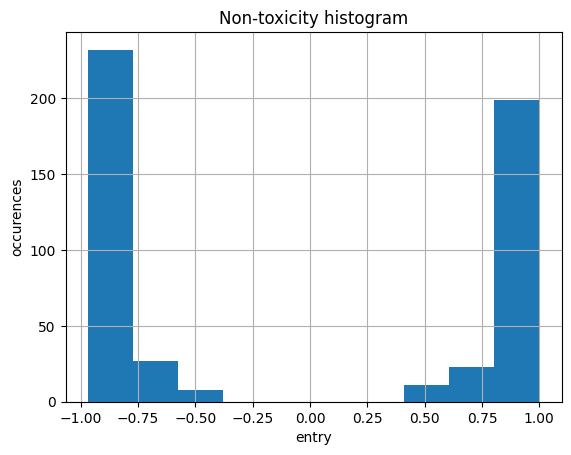

In [18]:
simple_hist(
    history_df["rate"],
    title="Non-toxicity histogram",
    xlabel="entry",
    ylabel="occurences",
    save_path="../reports/figures/bert_rate_hist.png",
)

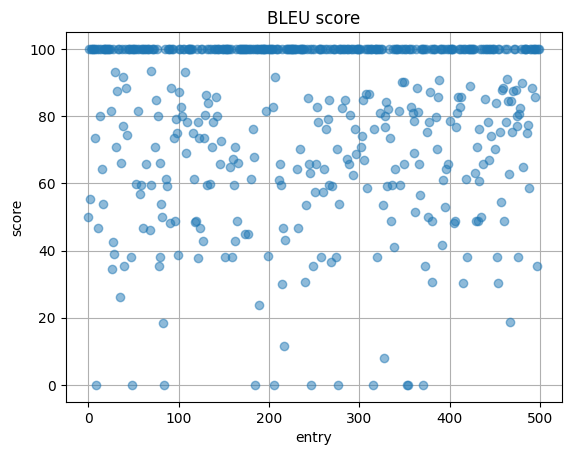

In [19]:
simple_plot(
    history_df["bleu_score"],
    title="BLEU score",
    xlabel="entry",
    ylabel="score",
    save_path="../reports/figures/bert_bleu.png",
    marker="o",
    linestyle="None",
    alpha=0.5,
)

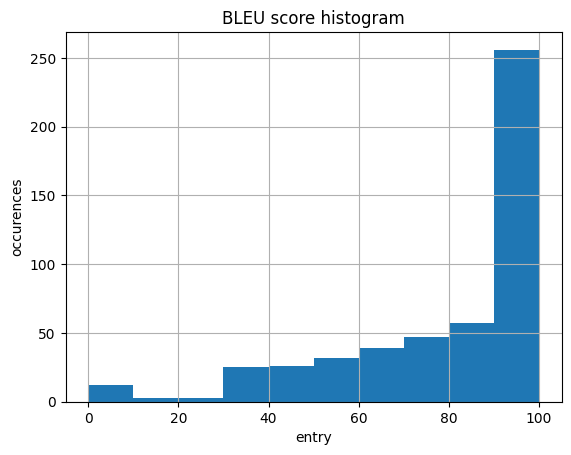

In [21]:
simple_hist(
    history_df["bleu_score"],
    title="BLEU score histogram",
    xlabel="entry",
    ylabel="occurences",
    save_path="../reports/figures/bert_bleu_hist.png",
)

# Conclusions:

Proposed approach is very dependent to the vocabulary we choose for evaluation.
One of the ways to overcome this issue is to use someone's else vocabulary to increase the chance of changing the toxic word.

However, we could go the other way:

- measure toxicity of the sentence using external model and replace words until it goes below some threshold

I believe that it is possible to achieve better results using this approach, but from now I will focus on adaptation of of the approach from lab - fine tuning t5 model to filter out toxic ones.
